In [3]:
import numpy as np
import json
import pandas as pd
import wandb
import os
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import cv2
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html
from ast import literal_eval

In [4]:
PATH = 'D:/Sumit/Python/Kaggle/tensorflow-great-barrier-reef/greatbarrierreef/train.csv'

In [5]:
data = pd.read_csv(PATH)

In [6]:
data.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


In [7]:
data['annotations'] = data['annotations'].apply(literal_eval)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        23501 non-null  int64 
 1   sequence        23501 non-null  int64 
 2   video_frame     23501 non-null  int64 
 3   sequence_frame  23501 non-null  int64 
 4   image_id        23501 non-null  object
 5   annotations     23501 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.1+ MB


In [9]:
categoryid = []
categoryname = []

for x in range(0,len(data['annotations'])):
    if data['annotations'][x] == []:
        y = 0
        z = 'without_COTS'
    else:
        y = 1
        z = 'with_COTS'
    categoryid.append(y)
    categoryname.append(z)

In [10]:
data['categoryid'] = categoryid
data['categoryname'] = categoryname

In [11]:
base_folder = "D:/Sumit/Python/Kaggle/tensorflow-great-barrier-reef/greatbarrierreef/train_images"

data["path"] = base_folder + "/video_" + \
                    data['video_id'].astype(str) + "/" +\
                    data['video_frame'].astype(str) +".jpg"

In [12]:
# Calculate the number of total annotations within the frame
data["no_of_annotations"] = data["annotations"].apply(lambda x: len(x))

In [13]:
data.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,categoryid,categoryname,path,no_of_annotations
0,0,40258,0,0,0-0,[],0,without_COTS,D:/Sumit/Python/Kaggle/tensorflow-great-barrie...,0
1,0,40258,1,1,0-1,[],0,without_COTS,D:/Sumit/Python/Kaggle/tensorflow-great-barrie...,0
2,0,40258,2,2,0-2,[],0,without_COTS,D:/Sumit/Python/Kaggle/tensorflow-great-barrie...,0
3,0,40258,3,3,0-3,[],0,without_COTS,D:/Sumit/Python/Kaggle/tensorflow-great-barrie...,0
4,0,40258,4,4,0-4,[],0,without_COTS,D:/Sumit/Python/Kaggle/tensorflow-great-barrie...,0


In [14]:
data[data['no_of_annotations']>10].head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,categoryid,categoryname,path,no_of_annotations
9292,1,8503,4140,312,1-4140,"[{'x': 1073, 'y': 274, 'width': 62, 'height': ...",1,with_COTS,D:/Sumit/Python/Kaggle/tensorflow-great-barrie...,11
9293,1,8503,4141,313,1-4141,"[{'x': 1076, 'y': 270, 'width': 67, 'height': ...",1,with_COTS,D:/Sumit/Python/Kaggle/tensorflow-great-barrie...,11
9294,1,8503,4142,314,1-4142,"[{'x': 1072, 'y': 268, 'width': 72, 'height': ...",1,with_COTS,D:/Sumit/Python/Kaggle/tensorflow-great-barrie...,11
9295,1,8503,4143,315,1-4143,"[{'x': 1074, 'y': 264, 'width': 73, 'height': ...",1,with_COTS,D:/Sumit/Python/Kaggle/tensorflow-great-barrie...,11
9296,1,8503,4144,316,1-4144,"[{'x': 1080, 'y': 260, 'width': 70, 'height': ...",1,with_COTS,D:/Sumit/Python/Kaggle/tensorflow-great-barrie...,11


https://www.kaggle.com/diegoalejogm/great-barrier-reefs-eda-with-animations

https://www.kaggle.com/andradaolteanu/greatbarrierreef-full-guide-to-bboxaugmentation#2.-%F0%9F%8C%8A-Dataset-Understanding

https://www.kaggle.com/coldfir3/simple-yolox-dataset-generator-coco-json

https://www.kaggle.com/ayuraj/visualize-bounding-boxes-interactively


In [15]:
# wandb.login(key= os.environ.get('wandb_password'))

# Secrets in case I am logging in through Kaggle Notebook

from kaggle_secrets import UserSecretsClient \
user_secrets = UserSecretsClient() \
secret_value_0 = user_secrets.get_secret("wandb")

In [16]:
def image(row):
    image = {}
    image["height"] = 720
    image["width"] = 1280
    image["id"] = row.image_id
    image["file_path"] = row.path
    return image

def category(row):
    category = {}
    category["supercategory"] = 'None'
    category["id"] = row.categoryid
    category["name"] = row.categoryname
    return category

def annotation(row):
    sub_list = []
    annotation_id = 0
    for bbox in row.annotations:
        annotation = {}
        annotation["segmentation"] = []
        annotation["iscrowd"] = 0
        annotation["area"] = bbox['width']* bbox['height']
        annotation["image_id"] = row.image_id

        annotation["bbox"] = list(bbox.values())

        annotation["category_id"] = row.categoryid
        annotation["id"] = annotation_id
        sub_list.append(annotation)
        annotation_id += 1
    return sub_list

In [17]:
def coco(df):    
    images = []
    categories = []
    annotations = []
    for row in tqdm(df.itertuples()):
        annotations.append(annotation(row))
        images.append(image(row))
        categories.append(category(row))

    json_file = {'categories':categories, 'images':images, 'annotations':annotations}

    return json_file

In [18]:
coco_data = coco(data)

23501it [00:00, 167711.93it/s]


Saving into a json file

In [19]:
save_json_path = 'coco_data_fastai.json'

json.dump(coco_data, open(save_json_path, "w"), indent=4)

OBJECT DETECTION USING FASTAI

In [20]:
from fastai.vision.all import *

In [21]:
f = open(save_json_path)
json_file = json.load(f)

In [23]:
imgs, lbl_bbox = get_annotations('coco_data_fastai.json')

TypeError: list indices must be integers or slices, not str

In [24]:
json_file.keys()

dict_keys(['categories', 'images', 'annotations'])

In [25]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations','categories']

In [26]:
y = json_file[CATEGORIES][16]

y

{'supercategory': 'None', 'id': 1, 'name': 'with_COTS'}

In [29]:
z = json_file[ANNOTATIONS][35]
z

[{'segmentation': [],
  'iscrowd': 0,
  'area': 4836,
  'image_id': '0-35',
  'bbox': [520, 151, 78, 62],
  'category_id': 1,
  'id': 0},
 {'segmentation': [],
  'iscrowd': 0,
  'area': 1856,
  'image_id': '0-35',
  'bbox': [598, 204, 58, 32],
  'category_id': 1,
  'id': 1}]

https://www.kaggle.com/karthikeyanvijayan/coco-object-detection-dataset-in-tfrecord 
\n
https://keras.io/examples/keras_recipes/creating_tfrecords/ 
\n
https://towardsdatascience.com/a-practical-guide-to-tfrecords-584536bc786c 
\n
https://www.tensorflow.org/install/source_windows 
\n
https://www.youtube.com/watch?v=yqkISICHH-U 
\n


In [58]:
# === Show image and annotations if applicable ===
def show_image(path, annot, axs=None):
    '''Shows an image and marks any COTS annotated within the frame.
    path: full path to the .jpg image
    annot: string of the annotation for the coordinates of COTS'''
    
    # This is in case we plot only 1 image
    if axs==None:
        fig, axs = plt.subplots(figsize=(23, 8))
    
    img = plt.imread(path)
    axs.imshow(img)

    if annot:
        for x in annot:
            a = x["bbox"]
            rect = patches.Rectangle((a[0], a[1]), a[2], a[3], 
                                     linewidth=2, edgecolor="#FF6103", facecolor='none')
            axs.add_patch(rect)

    axs.axis("off")

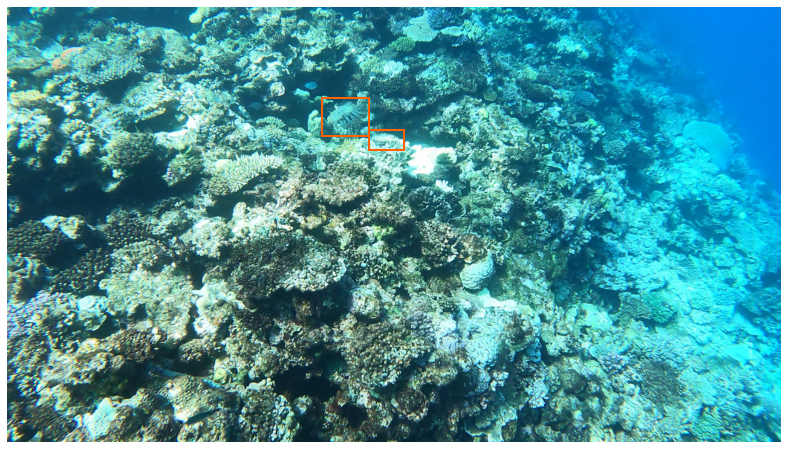

In [59]:
# Show only 1 image as example
path = json_file[IMAGES][35].get('file_path')
annot = json_file[ANNOTATIONS][35]

show_image(path,annot)

In [ ]:
# Show only 1 image as example
path = list(train_df[train_df["no_annotations"]==0]["path"])[0]
annot = list(train_df[train_df["no_annotations"]==0]["annotations"])[0]

In [ ]:
# W&B Experiment
run = wandb.init(project='GreatBarrierReef', name='ImageAnalysis', config=CONFIG, anonymous="allow")

# === Show image and annotations if applicable ===
def show_image(path, annot, axs=None):
    '''Shows an image and marks any COTS annotated within the frame.
    path: full path to the .jpg image
    annot: string of the annotation for the coordinates of COTS'''
    
    # This is in case we plot only 1 image
    if axs==None:
        fig, axs = plt.subplots(figsize=(23, 8))
    
    img = plt.imread(path)
    axs.imshow(img)

    if annot:
        for a in eval(annot):
            rect = patches.Rectangle((a["x"], a["y"]), a["width"], a["height"], 
                                     linewidth=3, edgecolor="#FF6103", facecolor='none')
            axs.add_patch(rect)

    axs.axis("off")
    
    
# === W&B Log ===
def wandb_annotation(image, annotations):
    '''Source: https://www.kaggle.com/ayuraj/visualize-bounding-boxes-interactively
    image: the cv2.imread() output
    annotations: the original annotations from the train dataset'''
    
    all_annotations = []
    if annotations:
        for annot in eval(annotations):
            data = {"position": {
                            "minX": annot["x"],
                            "minY": annot["y"],
                            "maxX": annot["x"]+annot["width"],
                            "maxY": annot["y"]+annot["height"]
                        },
                    "class_id" : 1,
                    "domain" : "pixel"}
            all_annotations.append(data)
    
    return wandb.Image(image, 
                       boxes={"ground_truth": {"box_data": all_annotations}}
                      )